# PCCA and TPT Analysis

This notebook follows the `step3-msm-analysis` notebook, updating the PyEmma tutorials for use with the `deeptime` package. It is based on this one of the PyEmma tutorials: http://www.emma-project.org/latest/tutorials/notebooks/05-pcca-tpt.html

From that tutorial:

> In this notebook, we will cover how to use PCCA++ to extract a coarse representation of the MSM. We will further investigate how to use transition path theory (TPT) to follow the pathways of the processes. When we want to analyze pathways, models with fewer states are more often desirable, since these are easier to understand. PCCA++ allows us to assign the microstates directly to metastable macrostates and TPT uses this group assignment to compute fluxes and pathways.

> Another method to get a model with fewer states are hidden Markov state models (HMM), introduced in Notebook 07 ➜ 📓. In contrast to computing memberships of microstates to meta stable sets as in PCCA++, in HMMs we directly obtain a model with fewer states.

> While we will mostly rely on previously estimated/validated models, it will be helpful to understand the topics - data loading/visualization (Notebook 01 ➜ 📓) - dimension reduction (Notebook 02 ➜ 📓) - the estimation and validation process (Notebook 03 ➜ 📓)

>! We have assigned the integer numbers $1 \dots $ `nstates` to PCCA++ metastable states. As PyEMMA is written in Python, it internally indexes states starting from 0. In consequence, numbers in the code cells differ by −1 from the plot labels and markdown text.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma

## Case 1: preprocessed, two-dimensional data (toy model)

We unpickle the data we pickled from our last step:

In [2]:
import pickle
fold = './data/'
fnames = ['step3-doublewell_cluster.pkl',
          'step3-doublewell_msm.pkl',
          'step3-doublewell_bayesian_msm.pkl']
varlist = []
for i in range(len(fnames)):
    f = open(fold+fnames[i],'rb')
    var = pickle.load(f)
    varlist.append(var)
    f.close()
    
cluster = varlist[0]
msm = varlist[1]
bayesian_msm = varlist[2]

In what follows, we borrow from the `deeptime` documentation and writeup of PCCA+ (https://deeptime-ml.github.io/trunk/notebooks/pcca.html), as well as the PyEmma tutorial.  Right now, we have our toy data clustered according to the variable `cluster` into 50 microstates, and we have estimated a maximum likelihood MSM (`msm`) from that clustered data.

In [8]:
print("Number of states: {}".format(msm.n_states))

Number of states: 50


Now we're going to search for a "coarse-graining" with PCCA+, which is a way of *fuzzily* assigning different microstates to macrostates.  "Fuzzily" means that rather than dividing up all microstates into exactly one associate macrostate, each microstate is given a probability of belonging to each macrostate.  As noted more formally in the documentation,

>Given a Markov state model with transition matrix $P \in \mathbb{R}^{n \times n}$, PCCA+ can cluster together (or coarse-grain) the $n$ microstates into $m<n$ *metastable sets* of states (macrostates) between which also a transition matrix

> $P_{macro} \in \mathbb{R}^{m \times m}$

>is defined.  The method works off of the assumption that the underlying Markov chain is reversible, i.e., given the stationary distribution $\pi$ it obeys the detailed balance condition

> $\pi_i P_{ij} = \pi_j P_{ji}$

> The result of the clustering is not only the coarse-grained transition matrix but one also obtains membership probabilities $M\in \mathbb{R}^{n \times m}$ giving a probability distribution of membership for each macrostate to each microstate.

Before we actually do the macrostate search, we need to decide how many metastable states we're looking for.  We know that it's two because this is our toy model, but if we were working with unknown data we wouldn't know that (recall when dealing with alanine dipeptide the number of metastable states becomes Dealer's Choice, as it were.)  One other trick suggested by the deeptime documentation for guesstimating the number of metastable states is to plot the transition matrix as a network, using "a connectivity threshold discarding weaker connections" though it is also noted that "this is not always possible and also not very rigorous."  But we'll take a look anyway.

In [9]:
import networkx as nx

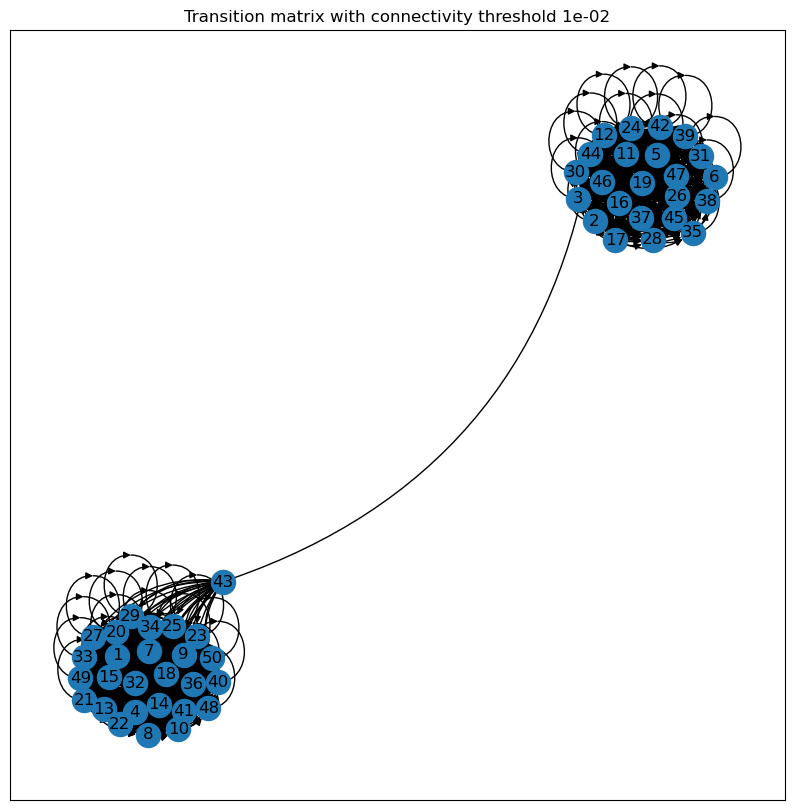

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

threshold = 1e-2
title = f"Transition matrix with connectivity threshold {threshold:.0e}"
G = nx.DiGraph()
ax.set_title(title)
for i in range(msm.n_states):
    G.add_node(i, title=f"{i+1}")
for i in range(msm.n_states):
    for j in range(msm.n_states):
        if msm.transition_matrix[i, j] > threshold:
            G.add_edge(i, j, title=f"{msm.transition_matrix[i, j]:.3e}")

edge_labels = nx.get_edge_attributes(G, 'title')
pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax, labels=nx.get_node_attributes(G, 'title'));
nx.draw_networkx_edges(G, pos, ax=ax, arrowstyle='-|>',
                       connectionstyle='arc3, rad=0.3');

In our toy data case, it's EXTREMELY clear that we only have two metastable states!  But, following the documentation,

> To make it rigorous, let us apply PCCA+ with two metastable states

In [11]:
n_metastable = 2
pcca = msm.pcca(n_metastable_sets=n_metastable)

> We obtain a coarse transition matrix

In [12]:
pcca.coarse_grained_transition_matrix

array([[0.93680094, 0.06319906],
       [0.04827882, 0.95172118]])

And we see that the jump probability between the two sets is about 5-6%.

>The memership probabilities can be accessed via `pcca.memberships`, where each column corresponds to a metastable set defining a probability distribution over the microstates:

In [13]:
print(f"Memberships: {pcca.memberships.shape}")

Memberships: (50, 2)


In [15]:
import mdshare, numpy as np
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']
assignments = cluster.transform(data)

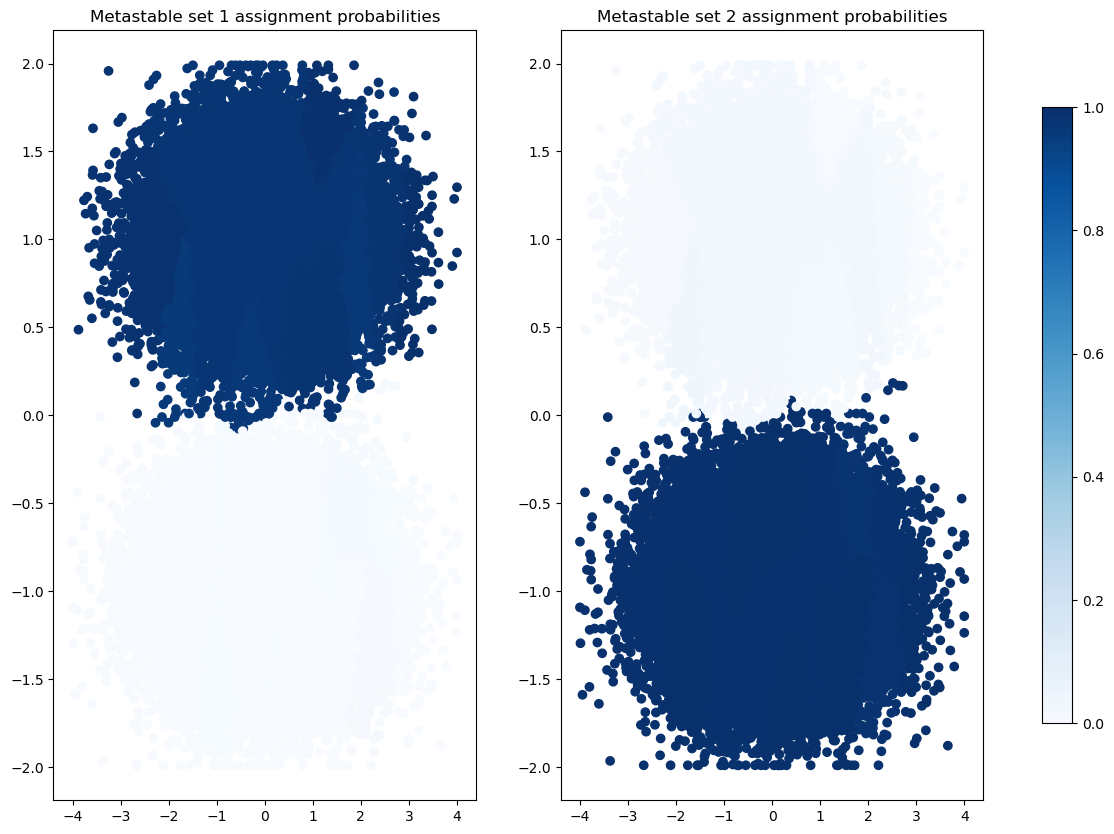

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

for i in range(len(axes)):
    ax = axes[i]
    ax.set_title(f"Metastable set {i+1} assignment probabilities")

    ax.scatter(*data.T, c=pcca.memberships[assignments, i], cmap=plt.cm.Blues)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8);

As expected, these fall very cleanly into two different metastable states.

> One has also access to a coarse-grained stationary probability vector

(much like the stationary probability vector for the microstates that we got out of the MSM in the previous step of the tutorial)

In [17]:
pcca.coarse_grained_stationary_probability

array([0.43307981, 0.56692019])

> Another offered quantity are the metastable distributions, i.e., the probability of metastable states to visit a micro state by PCCA+ 

> $\mathbb{P}\left(\textrm{state}_{\textrm{micro}}|\textrm{state}_{\textrm{pcca}} \right)$

In [18]:
print("Metastable distributions shape:", pcca.metastable_distributions.shape)

Metastable distributions shape: (2, 50)


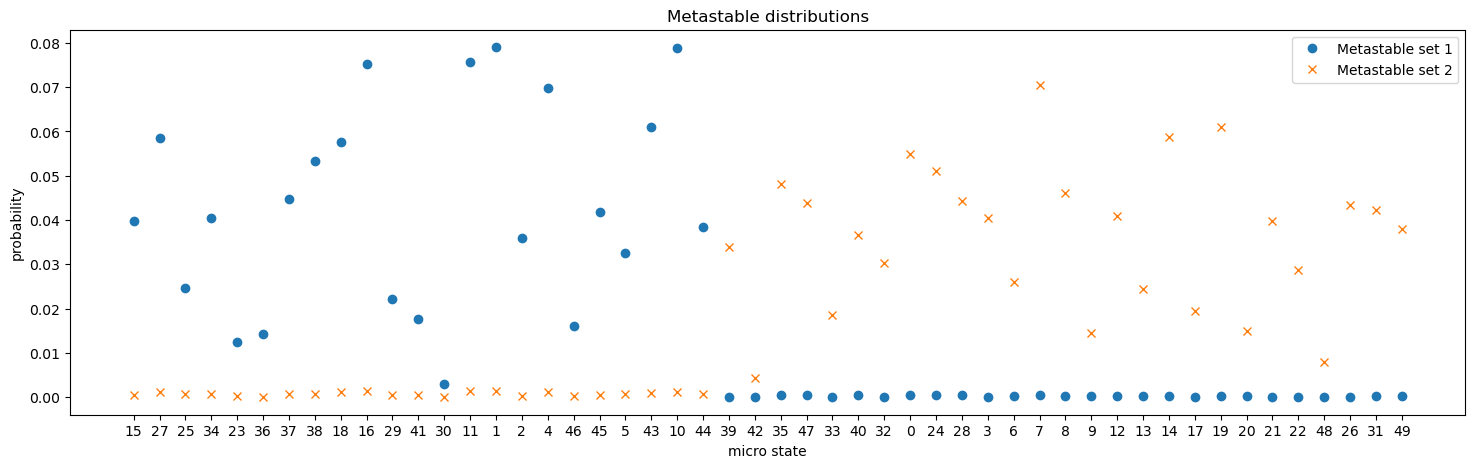

In [19]:
ix = np.argsort(pcca.assignments)
plt.figure(figsize=(18, 5))
plt.plot(np.arange(msm.n_states)+1, pcca.metastable_distributions[0][ix], 'o', label="Metastable set 1")
plt.plot(np.arange(msm.n_states)+1, pcca.metastable_distributions[1][ix], 'x', label="Metastable set 2")
plt.xticks(np.arange(msm.n_states)+1, [f"{i}" for i in ix])
plt.title("Metastable distributions")
plt.legend()
plt.xlabel('micro state')
plt.ylabel('probability');

This is basically telling you that if you know you start out knowing you're in macrostate 1 (or 2), you can figure out the probability of being in a given microstate according to the probabilities shown.  They're all quite small because there are about 25 states associated with each one and of course the probability of being in one of the microstates has to add to 1.  From the documentation,

>For all microstates one of the distribution values is approximately zero whereas the other one is greater than zero. This is because the microstates were separated well enough in the coarse graining.

They are talking about a different toy system with two wells but the observation also holds for this one.  Following on,

>For visualization purposes -- as in the plot above -- one can obtain the crisp assignments of microstates to macrostates through:

In [20]:
pcca.assignments

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1], dtype=int64)

In [134]:
pyemma_msm = pyemma.msm.estimate_markov_model(assignments,lag=1)
pyemma_msm.pcca(2)
pyemma_msm.metastable_sets

[array([ 1,  2,  4,  5, 10, 11, 15, 16, 18, 23, 25, 27, 29, 30, 34, 36, 37,
        38, 41, 43, 44, 45, 46], dtype=int64),
 array([ 0,  3,  6,  7,  8,  9, 12, 13, 14, 17, 19, 20, 21, 22, 24, 26, 28,
        31, 32, 33, 35, 39, 40, 42, 47, 48, 49], dtype=int64)]

In [136]:
np.where(pcca.assignments)[0]==pyemma_msm.metastable_sets[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [138]:
np.where(pcca.assignments==0)[0]==pyemma_msm.metastable_sets[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

> However, caution is appropriate, one *cannot* compute any actual quantity of the coarse-grained kinetics without employing the fuzzy memberships.

From the above, we double check and note that the `pcca.assignments` are the same as the `metastable_sets` that the PyEmma tutorial calculates and uses, without explicitly noting that that is what they are.  So we've given up on the fuzziness even though we have used PCCA.

Next, we move on to Transition Path Theory, for which we again follow the `deeptime` documentation, this time the TPT tutorial: https://deeptime-ml.github.io/trunk/notebooks/tpt.html. This time we are going to do their toy model first, before moving back to our original two-well model.

### Case 1.5: The Drunkard's Walk

From `deeptime` (please see their link to get to the literature references they build the discussion on!)

> Transition path theory (TPT) is a method to study the ensemble of reactive trajectories, i.e., trajectories which come from a defined set of states $A$ and go next to $B$. It can answer at which rate they occur, as well as depict parallel pathways, traps, sequences of events, etc. Furthermore it introduces the notion of 'committor functions', which deals with probabilities of ending up in set $A$ or $B$ given that the trajtectory stats at some state potentially outside of $A \cup B$.

> ... in the following, the example of a drunkard's walk is presented. The example is motivated by [5] and [6] (see `deeptime`), where a drunkard is placed on a network of states and two special states, home and the bar. When the drunkard reaches either of these special states the trajectory stays there with high probability. One can then ask which paths can be taken and also with which probability the drunkard is going to reach either of the states given a certain current position.

> We can create a `DrunkardsWalk` simulator by specifying bar and home locations. As the drunkard lives on a 2-dimensional grid, the locations are given in terms of integer coordinates.  Internally, this is related back to $\textrm{width} \times \textrm{height}$ states.

>There are four kinds of states:

> * home states: states which denote the location of the home

> * bar states: states which denote the location of the bar

> * barrier states: states which either cannot be crossed or can only be crossed by overcoming a potential (i.e., it is less likley to encoutner these states in a trajectory)

> * normal states: the drunkard can move freely by taking a step onto one of the adjacent grid cells with uniform probability unless it is a barrier.

In [24]:
from deeptime.data import drunkards_walk

sim = drunkards_walk(grid_size=(10, 10),
                     bar_location=[(0, 0), (0, 1), (1, 0), (1, 1)],
                     home_location=[(8, 8), (8, 9), (9, 8), (9, 9)])


> We can add hard and soft barriers by specifying start and end points of the barrier.  If no weight is given, the barrier is `hard`, i.e., cannot be crossed by a trajectory.  This enters the jump probabilities from adjacent cells $(i,j)$ as

> $ \mathbb{P}\left(x_{t+1}=\textrm{barrier}|x_t = (i,j) \right) = \begin{cases} 
 p \leq 1/\textrm{weight} & \textrm{ if weight positive,} \\
 0 & \textrm{, otherwise}
\end{cases}$

> This means the larger the weight, the smaller the probability to cross the barrier.

In [25]:
sim.add_barrier((5, 1), (5, 5))
sim.add_barrier((0, 9), (5, 8))
sim.add_barrier((9, 2), (7, 6))
sim.add_barrier((2, 6), (5, 6))

sim.add_barrier((7, 9), (7, 7), weight=5.)
sim.add_barrier((8, 7), (9, 7), weight=5.)

sim.add_barrier((0, 2), (2, 2), weight=5.)
sim.add_barrier((2, 0), (2, 1), weight=5.)

> Now we can simulated a trajectory on this grid by specifying a starting point and a number of simulation steps. The effective length of the trajectory might be lower than the number of simulation steps as the simulation stops if the state is `home` or `bar`.

In [26]:
start = (7, 2)
walk = sim.walk(start=start, n_steps=250, seed=40)
print("Number of steps in the walk:", len(walk))

Number of steps in the walk: 74


> The trajectory can be visualized witha  few helper functions attached to the smulator:

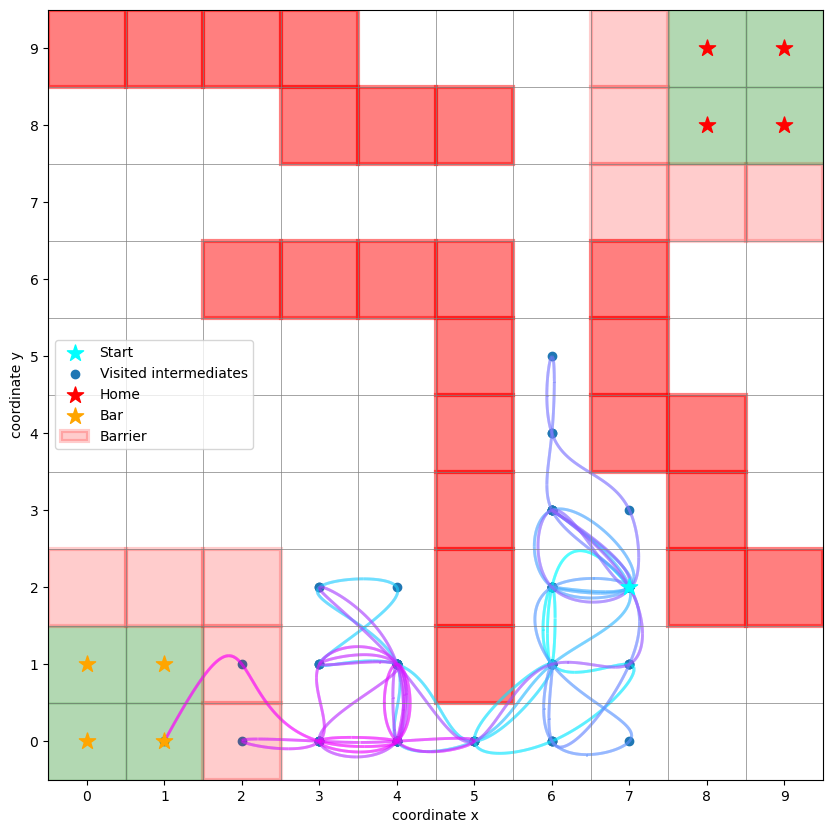

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(*start, marker='*', label='Start', c='cyan', s=150, zorder=5)
sim.plot_path(ax, walk, intermediates=True,color_lerp=True)
handles, labels = sim.plot_2d_map(ax)
ax.legend(handles=handles, labels=labels);

In [30]:
help(sim.plot_path)

Help on function plot_path in module deeptime.data._drunkards_walk_simulator:

plot_path(ax, path, intermediates: bool = True, color_lerp: bool = True, **plot_kw)
    Plots a path onto a drunkard's walk map. The path is interpolated with splines and, if desired, has a
    linearly interpolated color along its path.
    
    Parameters
    ----------
    ax : matplotlib axis
        The axis to plot onto.
    path : (N, 2) ndarray
        The path in terms of 2-dimensional coordinates.
    intermediates : bool, default=True
        Whether to scatterplot the states that were visited in the path.
    color_lerp : bool, default=True
        Whether to perform a linear interpolation along a colormap while the path progresses through the map.
    plot_kw
        Additional args that go into either a `ax.plot` call (`lerp=False`) or into a `LineCollection(...)` call
        (`lerp=True`).



The color here denotes how far along the path the drunkard is (starts cyan, ends magenta, gradually transitions between one and the other.)

>the darker red squares denoted hard barriers, the light red squares barriers which can be crossed. So one could imagine that both home and bar are on a hill.

>The simulator internally holds a `MarkovStateModel` on which one can call `reactive_flux(A,B)`. This computes some quantities related to the ensemble of reactive trajectories between sets of states $A$ and $B$.

In [65]:
sim.home_state

[88, 98, 89, 99]

In [66]:
sim.bar_state

[0, 10, 1, 11]

In [35]:
print(f"Internal Markov state model with {sim.msm.n_states} states to cover the {sim.grid_size} grid.")
print(f"Compute reactive flux from A={sim.home_state} to B={sim.bar_state}")
flux = sim.msm.reactive_flux(sim.home_state, sim.bar_state)

Internal Markov state model with 100 states to cover the (10, 10) grid.
Compute reactive flux from A=[88, 98, 89, 99] to B=[0, 10, 1, 11]


In [37]:
flux

ReactiveFlux-1973372917120:[{'gross_flux': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                                  [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                                  [0.00000000e+00, 5.91233575e-06, 0.00000000e+00, ...,
                                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                                  ...,
                                  [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                                   0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                                  [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                                   8.53022302e-06, 0.00000000e+00, 0.00000000e+00],
                                  [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ..

#### The committor

> One of the questions that can be answered with TPT is: If the man is at some state $(i,j)$, what is the probability that he reaches the bar before home?  If he is already at the bar, the probability is 1, i.e.,

> $\mathbb{P}((i,j)) = 1 \forall (i,j) \in \textrm{Bar}$

> and vice versa

> $\mathbb{P}((i,j)) = 0 \forall (i,j) \in \textrm{Home}$

> The law of total probability tells us that to know the probability of an event $A$ given a known and at most countably infinite set of mutually exclusive events $\left\{C_n : n \in \mathbb{N}\right\}$ so that $\sum_i \mathbb{P}\left(C_i \right)=1$, one can evaluate

> $\mathbb{P}(A) = \sum_n \mathbb{P}\left(\left. A \right| C_n\right) \mathbb{P}\left(C_n\right).$ 

(That is, we can relate the probability of $A$ to its conditional and marginal probabilities -- or, in other words, to figure out how likely $A$ is we can just add up how likely it is given a set of all the conditions leading to $A$.)

> In our example and ignoring borders and barriers, this means that for a current state $s = (i,j)$ and $A = \textrm{"Home from state }s\textrm{"}$, the sample space consistes of direct neighbor states, i.e.,

> $C = \left\{\textrm{move from }s\textrm{ to }s+(k,l)\textrm{ : }(k,l)\in \left\{-1,0,1 \right\}^2 \textrm{ and }(k,l)\neq(0,0) \right\}$

> Then,

> $\mathbb{P}\left(\textrm{Home from }s \right) = \sum_{C_{k,l} \in C}\mathbb{P}\left(\textrm{Home from }s+(k,l) \right) \mathbb{P}\left(C_{(k,l)} \right)$

> But the $\mathbb{P}\left(C_{(k,l)} \right)$ are exactly the transition probabilities to move from state $s$ to $s+(k,l)$, giving rise to the *forward committor*,

> $q_s^{(+)} = q_{(i,j)}^{(+)} = \sum_{(k,l)\neq (0,0)}q^{(+)}_{(i+k,j+l)}p_{(i,j),(i+k,j+l)},$

> where $p_{(i,j),(i+k,j+l)}$ is the probability to transition from state $s=(i,j)$ to one of its neighboring states.

> **More formally**, the forward committor probability is the probability to reach set of states $A$ before $B$.  Using the first hitting time of a set $S$ given by

> $T_s = \inf\left\{t\geq0\textrm{ : }X_t \in S \right\},$

> it can be defined as

> $q_i^{(+)}=\mathbb{P}_i(T_A < T_B).$

>It also satisfies the boundary value problem (BVP)

>$q_i^{(+)} = 0, \textrm{ for all } i \in A,$

>$q_i^{(+)} = 1, \textrm{ for all } i \in B,$

>$\sum_j L_{ij}q_j^{(+)} = 0, \textrm{ for all } i \notin A \cup B,$ 

> where $L = P - \mathbb{I}$ is the generator matrix and $P$ the transition matrix.  The BVP-formulation is used to numerically find the forward committor.

> There is also the notion of a *backward committor*, which is the probability that given state $i$, the system has previously been in set $A$ rather than $B$. With detailed balance, the backward committor is given by $q_i^{(-)} = 1 - q_i^{(+)}$.

In [38]:
flux.forward_committor

array([1.        , 1.        , 0.89697164, 0.79617691, 0.77601418,
       0.73152071, 0.68969671, 0.676312  , 0.67153358, 0.67045458,
       1.        , 1.        , 0.87616934, 0.7958701 , 0.780489  ,
       0.72880445, 0.67988297, 0.67107115, 0.66937558, 0.67045458,
       0.89765175, 0.87650295, 0.83106084, 0.79359419, 0.78975793,
       0.72089765, 0.65426961, 0.65642761, 0.56354749, 0.47393435,
       0.7984827 , 0.79635405, 0.79260338, 0.78983317, 0.78900319,
       0.70611281, 0.63198317, 0.63198317, 0.36308913, 0.08197287,
       0.78150598, 0.78215021, 0.78379729, 0.78542   , 0.78641066,
       0.67822446, 0.58525229, 0.48459641, 0.19197493, 0.08197287,
       0.76333077, 0.76721216, 0.77391534, 0.78289004, 0.7849069 ,
       0.60933783, 0.49179054, 0.32847595, 0.08197287, 0.08197287,
       0.74376316, 0.74202236, 0.73137758, 0.69824712, 0.62156282,
       0.48787843, 0.39832878, 0.27019302, 0.08503528, 0.07891047,
       0.72707876, 0.71917176, 0.69968454, 0.63474686, 0.51333

In [39]:
flux.backward_committor

array([0.        , 0.        , 0.10302836, 0.20382309, 0.22398582,
       0.26847929, 0.31030329, 0.323688  , 0.32846642, 0.32954542,
       0.        , 0.        , 0.12383066, 0.2041299 , 0.219511  ,
       0.27119555, 0.32011703, 0.32892885, 0.33062442, 0.32954542,
       0.10234825, 0.12349705, 0.16893916, 0.20640581, 0.21024207,
       0.27910235, 0.34573039, 0.34357239, 0.43645251, 0.52606565,
       0.2015173 , 0.20364595, 0.20739662, 0.21016683, 0.21099681,
       0.29388719, 0.36801683, 0.36801683, 0.63691087, 0.91802713,
       0.21849402, 0.21784979, 0.21620271, 0.21458   , 0.21358934,
       0.32177554, 0.41474771, 0.51540359, 0.80802507, 0.91802713,
       0.23666923, 0.23278784, 0.22608466, 0.21710996, 0.2150931 ,
       0.39066217, 0.50820946, 0.67152405, 0.91802713, 0.91802713,
       0.25623684, 0.25797764, 0.26862242, 0.30175288, 0.37843718,
       0.51212157, 0.60167122, 0.72980698, 0.91496472, 0.92108953,
       0.27292124, 0.28082824, 0.30031546, 0.36525314, 0.48666

In [40]:
flux.forward_committor.shape

(100,)

The forward and backward committors in this case are of length 100 because there are 100 states on a $10 \times 10$ grid. We can visualize the related probabilities using the code from the `deeptime` tutorial, which reshapes the 100 length vector into a $10 \times 10$ array that is then visualized (on a similar grid setup to the previous) with good old mainstay `imshow`:

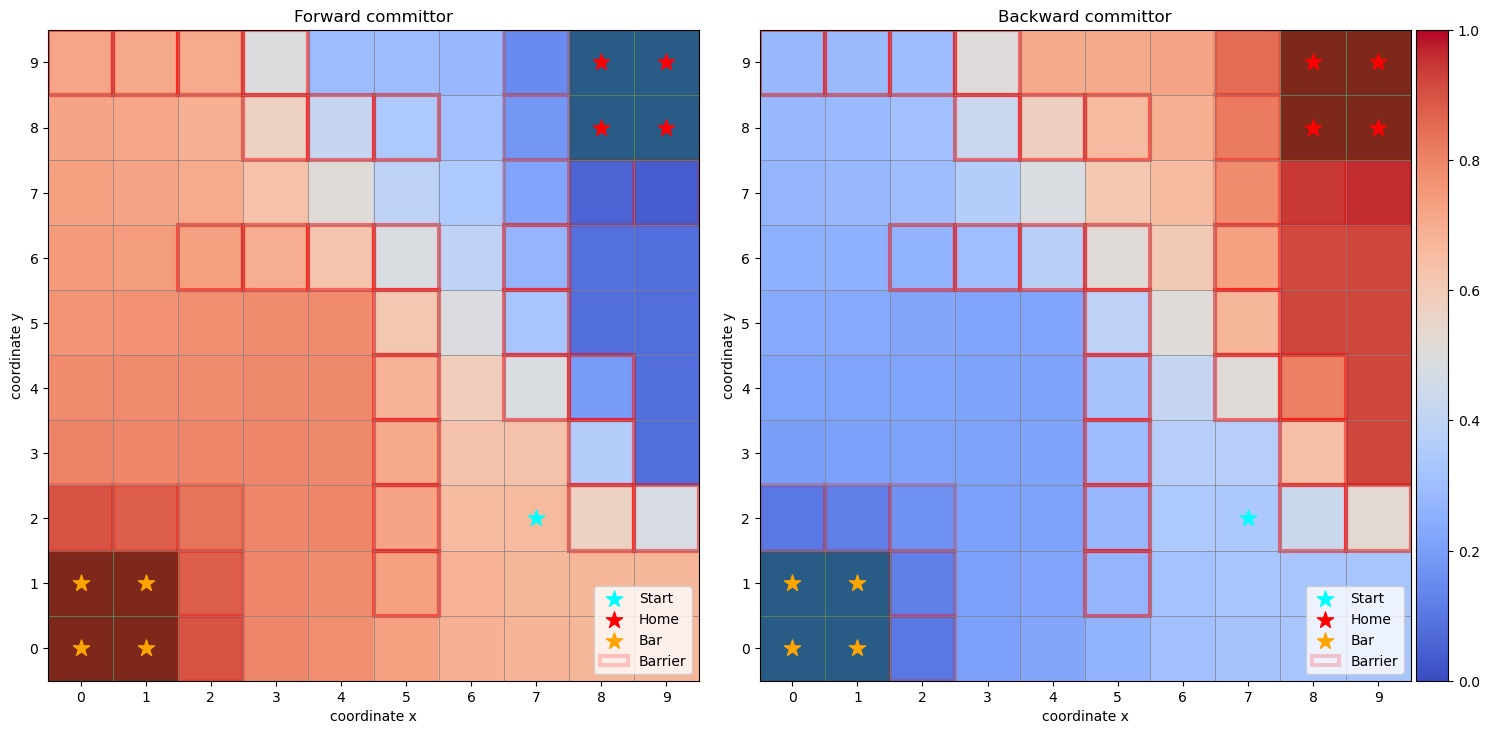

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
dividers = [make_axes_locatable(axes[i]) for i in range(len(axes))]
caxes = [divider.append_axes("right", size="5%", pad=0.05) for divider in dividers]
titles = ["Forward committor", "Backward committor"]

for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.scatter(*start, marker='*', label='Start', c='cyan', s=150, zorder=5)
    handles, labels = sim.plot_2d_map(ax, barrier_mode='hollow')

    if i == 0:
        Q = flux.forward_committor.reshape(sim.grid_size)
    else:
        Q = flux.backward_committor.reshape(sim.grid_size)
    cb = ax.imshow(Q, interpolation='nearest', origin='lower', cmap='coolwarm')
    fig.colorbar(cb, cax=caxes[i])
    if i == 0:
        fig.delaxes(fig.axes[2])

    ax.legend(handles=handles, labels=labels)


plt.tight_layout()

Because we computed the `flux` from $A$ (Home) to $B$ (Bar), the forward committor specifically answers the question of how do we get to the to-state (the Bar) from the from-state (the Home).

>As one can observe, the forward committor probabilities increase gradually when moving from home to bar, vice versa for the backward committor. This is expected as the Markov state model is reversible.

### Reactive probability flux

> If one is interested in the current of trajectories making their way from a set of states $A$ to a set of states $B$ (without trajectories that, e.g., leave $A$ just to go back to $A$ and only then enter $B$, TPT offers the *reactive flux*. The relevant *gross flux* between two states $i$ and $j$ is then given by

> $f_{ij}^{AB} = \begin{cases}
q_i^{(-)}\pi_i p_{ij} q_j^{(+)} &, \textrm{ if } i\neq j,\\
0 &, \textrm{ otherwise}.
\end{cases}$

That is to say, the *gross flux* -- meaning how much probability flows through $i\rightarrow j$ on its way from $A$ to $B$-- is the probability that you got to state $i$ by starting in the set of states $A$ times the stationary probability of getting to state $i$ at all, times the probability of moving from state $i$ to state $j$ times the probability of being able to get to the set of states $B$ from state $j$, because we're specifically interested in getting from $A$ to $B$ via our in-between states, which adds us additional committor probabilities (also suggesting why we've called them *committors* -- we're *committing* to either a starting point or an ending point by thinking about it this way.

> The flux is conserved between intermediate states

> $\sum_j f_{ij}^{AB} - f_{ji}^{AB} = 0 \forall i \notin A \cup B,$

> and also through the entire network

> $\sum_{i \in A, j \notin A}f_{ij}^{AB} = \sum_{i \notin B, j \in B} f_{ij}^{AB}.$

>The considered *gross flux* can include detours of the form $A\rightarrow ... \rightarrow i \rightarrow j \rightarrow i \rightarrow j \rightarrow ... \rightarrow B$, which can be (in the case of detailed balance) excluded by considering the *net flux*

> $f_{ij}^{AB,+} = \max\left\{0, f_{ij}^{AB}-f_{ji}^{AB} \right\}.$

>In gnereal and without detailed balance, the net flux might still contain such detours.

> In `deeptime`, the gross and net flux are accessible from the `ReactiveFlux` object as $\left(n_{\textrm{states}} \times n_{\textrm{states}} \right)$ numpy arrays, where the first dimension corresponds to state $i$, the second dimension corresponds to state $j$.

In [42]:
print(f"Gross flux shape {flux.gross_flux.shape}, net flux shape {flux.net_flux.shape}")

Gross flux shape (100, 100), net flux shape (100, 100)


> The example simulator offers plotting functionality so that the fluxes can be visualized:

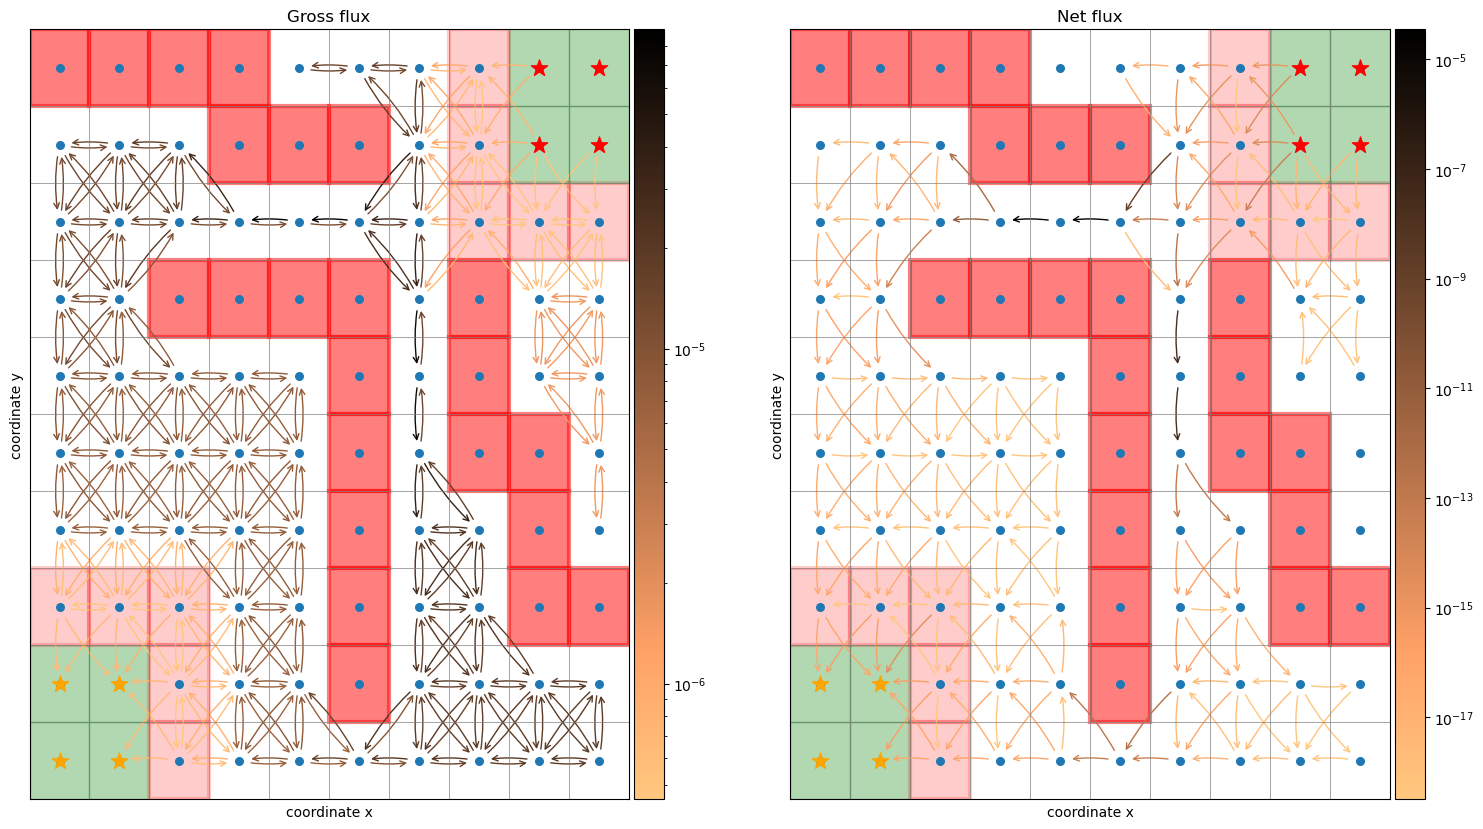

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
dividers = [make_axes_locatable(axes[i]) for i in range(len(axes))]
caxes = [divider.append_axes("right", size="5%", pad=0.05) for divider in dividers]

titles = ["Gross flux", "Net flux"]
fluxes = [flux.gross_flux, flux.net_flux]

cmap = plt.cm.copper_r
thresh = [0, 1e-12]

for i in range(len(axes)):
    ax = axes[i]
    F = fluxes[i]
    ax.set_title(titles[i])

    vmin = np.min(F[np.nonzero(F)])
    vmax = np.max(F)

    sim.plot_2d_map(ax)
    sim.plot_network(ax, F, cmap=cmap, connection_threshold=thresh[i])
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=caxes[i]);

> From the gross flux one can derive the *total flux*, the total number of reactive $A\rightarrow B$ trajectories per time unit

> $f_{\textrm{tot}}^{AB} = \sum{i \in A, j \notin A}f_{ij}^{AB},$,

>which can be accessed by,

In [44]:
print(f"Total flux = {flux.total_flux:.3e}/step")

Total flux = 6.165e-05/step


>This quantity gives rise to the *total transition rate*, which is the number of events given we start in $A$,

>$k_{AB} = \frac{f_{\textrm{tot}^{AB}}}{\sum_i \pi_i q_i^{(-)}}$

In [45]:
print(f'Rate = {flux.rate:.3e}/step')

Rate = 1.264e-04/step


> which is also the inverse of the mean first passage time from $A \rightarrow B$ -- $\textrm{mfpt} = 1/{k_{AB}}$

In [46]:
print(f'MFPT = {flux.mfpt:.3f} steps')

MFPT = 7911.887 steps


### Coarse-graining of fluxes

> For better interpretability, on can cluster microstates defined in our MSM into metastable sets using e.g. PCCA+

> In our example, we might select six clusters:

In [48]:
pcca = sim.msm.pcca(n_metastable_sets=6)

> and depict the membership probabilities for each state

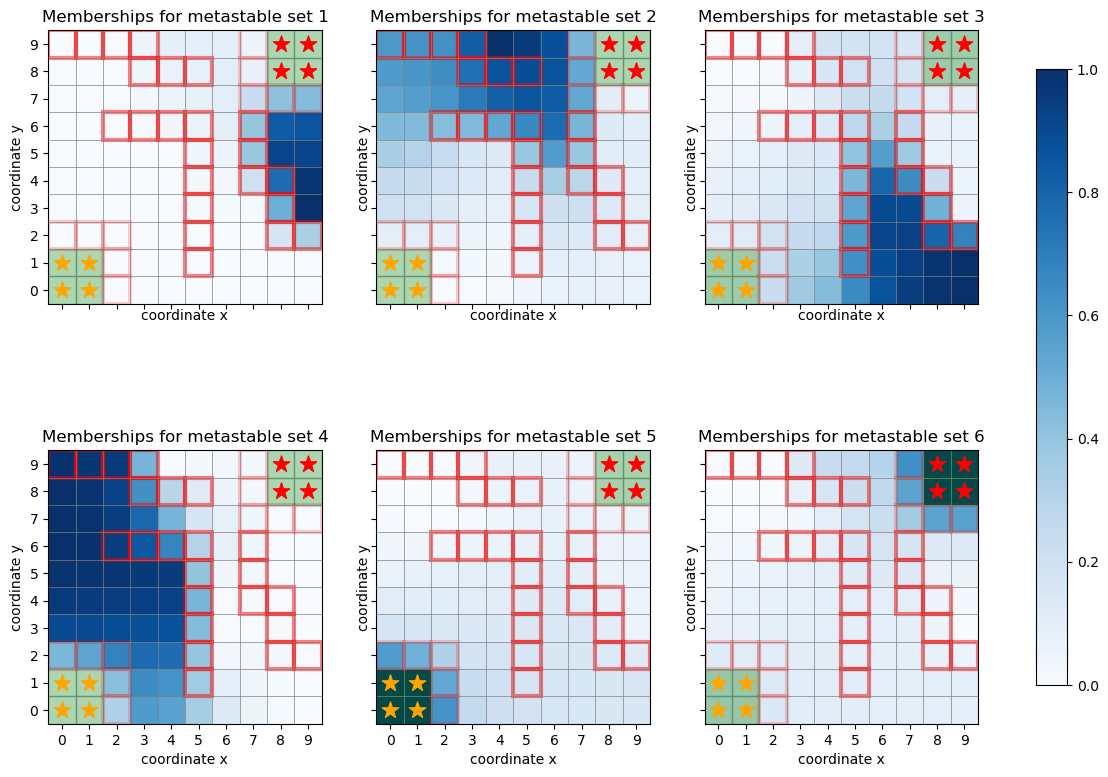

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax.set_title(f"Memberships for metastable set {i+1}")
    handles, labels = sim.plot_2d_map(ax, barrier_mode='hollow')

    Q = pcca.memberships[:, i].reshape(sim.grid_size)
    cb = ax.imshow(Q, interpolation='nearest', origin='lower', cmap=plt.cm.Blues);
norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8);

> Also reactive fluxes can be coarse-grained by lumping together states - without systematic error as in the PCCA case. For simplicity, we coarse grain onto $A,B$, and the remainder subdivided into the upper half $(j\geq 5)$ and the lower half.

In [50]:
remainder_upper = []
remainder_lower = []
for i in range(sim.grid_size[0]):
    for j in range(sim.grid_size[1]):
        state = sim.coordinate_to_state((i, j))
        if state not in sim.home_state + sim.bar_state:
            if j >= 5:
                remainder_upper.append(state)
            else:
                remainder_lower.append(state)

In [51]:
sets, tpt = flux.coarse_grain([sim.home_state, sim.bar_state, remainder_upper, remainder_lower])

>As expected (by definition) we obtain four sets which are exactly the home states, the bar states, and the subdivided remainder

In [53]:
sim.n_states

100

In [55]:
type(sets)

list

In [56]:
len(sets)

4

In [57]:
type(sets[0])

set

In [59]:
len(sets[1])

46

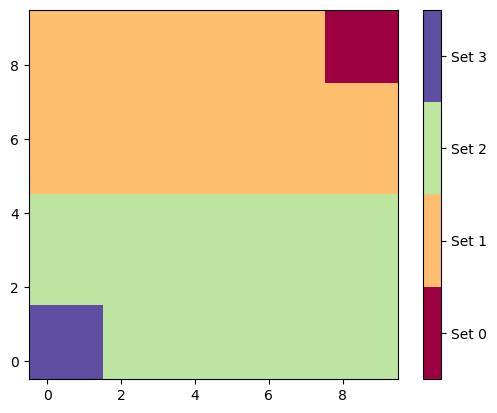

In [52]:
# enumerating assignments
assignments = np.zeros(sim.n_states)
for i, flux_set in enumerate(sets):
    assignments[np.array(list(flux_set))] = i
assignments = assignments.reshape(sim.grid_size)

# plot assignments
fig, ax = plt.subplots(1, 1)
cmap = plt.cm.get_cmap('Spectral', 4)
cb = ax.imshow(assignments, interpolation='nearest', origin='lower',
               cmap=cmap, vmin=-.5, vmax=3.5)
cbar = fig.colorbar(cb, ticks=np.arange(4))
cbar.ax.set_yticklabels(['Set 0', 'Set 1', 'Set 2', 'Set 3']);

So, as we can see, when we called `coarse_grain`, it popped us back a set of sets that was just the sets we had defined, and then it also gives us `tpt`.

In [60]:
tpt

ReactiveFlux-1973381562224:[{'gross_flux': array([[0.00000000e+00, 6.16520043e-05, 0.00000000e+00, 0.00000000e+00],
                                  [0.00000000e+00, 0.00000000e+00, 7.87786547e-04, 0.00000000e+00],
                                  [0.00000000e+00, 7.26134543e-04, 0.00000000e+00, 6.16520043e-05],
                                  [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
                            'net_flux': array([[0.00000000e+00, 6.16520043e-05, 0.00000000e+00, 0.00000000e+00],
                                  [0.00000000e+00, 0.00000000e+00, 6.16520043e-05, 0.00000000e+00],
                                  [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.16520043e-05],
                                  [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
                            'qminus': None,
                            'qplus': None,
                            'source_states': [0],
                            's

According to the tutorial, `tpt` "also contains the fluxes plus derived quantities:  The gross flux has a forward-backward cycle between upper and lower set, while the net flux lacks this cycle."

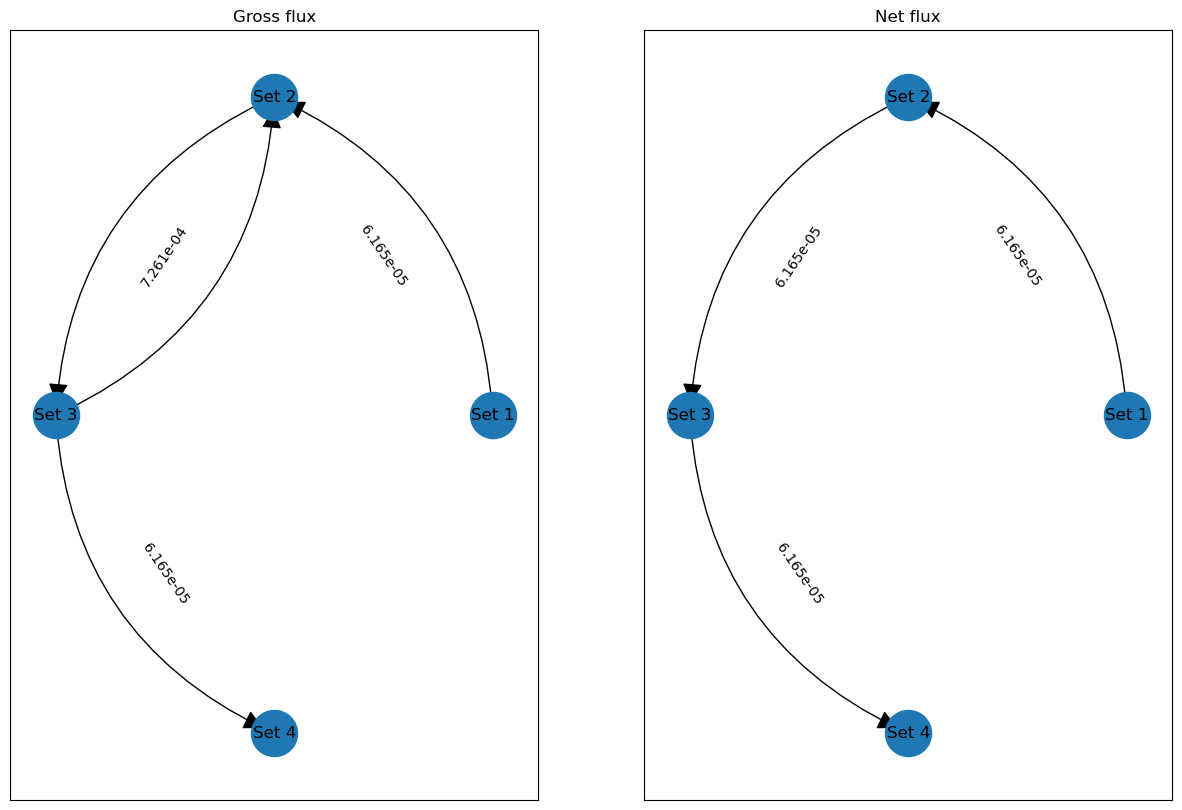

In [62]:
import networkx as nx

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
graphs = [nx.DiGraph() for _ in range(len(axes))]

for i in range(len(axes)):
    ax = axes[i]

    ax.set_title("Gross flux" if i == 0 else "Net flux")

    F = tpt.gross_flux if i == 0 else tpt.net_flux
    G = graphs[i]
    for i in range(len(sets)):
        G.add_node(i, title=f"Set {i+1}")
    for i in range(len(sets)):
        for j in range(len(sets)):
            if F[i, j] > 0:
                G.add_edge(i, j, title=f"{F[i, j]:.3e}")

    edge_labels = nx.get_edge_attributes(G, 'title')
    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=1100)
    nx.draw_networkx_labels(G, pos, ax=ax, labels=nx.get_node_attributes(G, 'title'));
    fragments = nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_labels)
    nx.draw_networkx_edges(G, pos, ax=ax, arrowstyle='-|>', arrowsize=30,
                           connectionstyle='arc3, rad=0.3');

### Pathway decomposition

> A pathway is a sequence of states $P = (s_1,s_2,...,s_k)$ so that $s_1 \in A$ and $s_k \in B$. One can associate a capacity (the minimal current) to a pathway via

> $f(P) = \min\left\{f_{s_i s_{i+1}}^{AB} \textrm{ : }i=1,...,k-1 \right\}$

> A pathway decomposition is then the repeated choosing of a path and subsequent removal of its capaicty along its edges until no flux remains.

> The decomposition is not unique and depnds on the order in which the paths are chosen.  In `deeptime`, a pathway decomposition is implemented by iteratively removing the currently strongest pathway (i.e. with largest capacity).

>A call to `pathways()` performs said operation.  One can optionally give a fraction (default 1.0) which stops the decomposition when the given fraction of the total flux is reached with the decomposition.  The default tries to sort the flux into all dominant pathways which can be computationally intensive for large networks.  Furthermore one can set a hard limit on the number of computed pathways via the `maxiter` argument.

In [63]:
paths, capacities = flux.pathways(fraction=.3, maxiter=1000)
print(len(paths))

4


In [64]:
paths

[array([88, 77, 66, 56, 46, 37, 27, 16,  5,  4,  3,  2, 11]),
 array([98, 87, 76, 66, 56, 46, 37, 26, 16,  5,  4, 13,  2,  1],
       dtype=int32),
 array([98, 97, 86, 75, 74, 73, 72, 61, 50, 40, 30, 20, 10], dtype=int32),
 array([88, 97, 96, 86, 76, 66, 56, 46, 36, 26, 17,  6,  5, 14,  3, 12, 11],
       dtype=int32)]

> In this example, we can represent 30% of the total flux with four pathways.

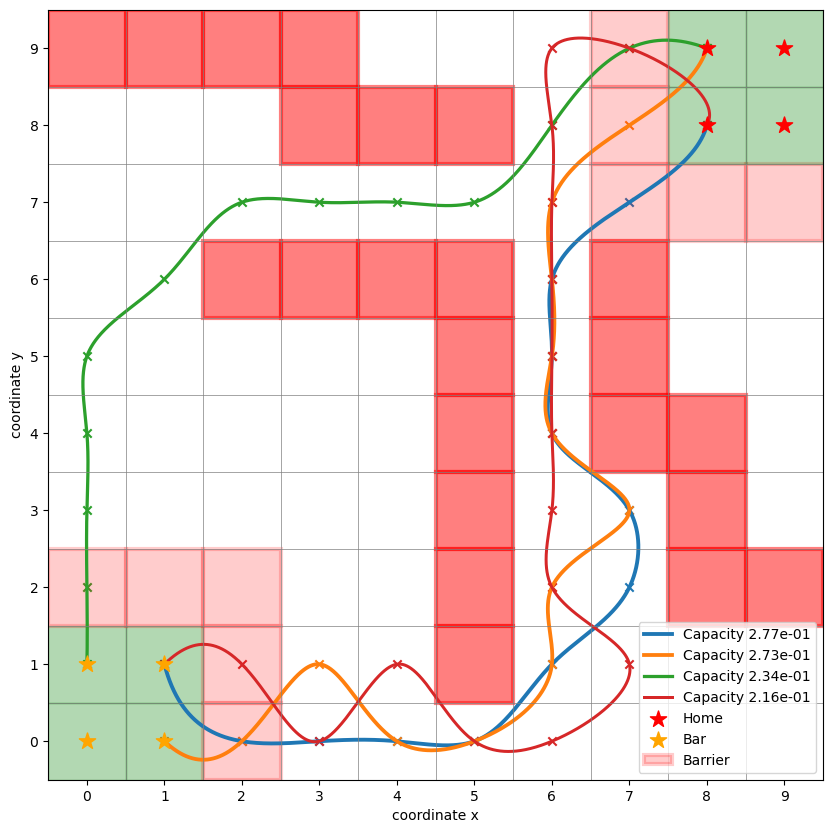

In [68]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 10))

#ax.scatter(*start, marker='*', label='Start', c='cyan', s=150, zorder=5)

for capacity, path in zip((capacities / np.array(capacities).sum())[:10], paths[:10]):
    path = np.array([sim.state_to_coordinate(state) for state in path])
    sim.plot_path(ax, path, lw=capacity*10, intermediates=False,
                  color_lerp=False, label=f"Capacity {capacity:.2e}")
    ax.scatter(*path.T, marker='x')

handles, labels = sim.plot_2d_map(ax)
ax.legend(handles=handles, labels=labels);

### Example from trajectories

> Using the same example we can generate timeseries which can be used to re-estimate a MSM and perform a TPT analysis.  To this end, we simulation 1000 trajectories all startin gfrom the same point and return the micro states directly rather than $(i,j)$ coordinates.

In [69]:
trajs = []
for _ in range(1000):
    trajs.append(sim.walk(start=start, n_steps=2000, return_states=True, stop=False))

> From these trajectories we can count state transitions based on the prior knowledge that there are actually 100 states and select the largest connected submodel - which due to the barriers does not contain all the states

In [70]:
from deeptime.markov import TransitionCountEstimator

count_model = TransitionCountEstimator(1, 'sliding', n_states=sim.n_states) \
    .fit(trajs).fetch_model()
count_model = count_model.submodel_largest()

In [71]:
print(f"States not included in the count model: "
      f"{set(range(count_model.n_states_full)) - set(count_model.state_symbols)}")

States not included in the count model: {15, 25, 28, 29, 35, 38, 45, 47, 48, 55, 57, 62, 63, 64, 65, 67, 83, 84, 85, 90, 91, 92, 93}


> Based on this we can estimate a Markov state model:

In [72]:
from deeptime.markov.msm import MaximumLikelihoodMSM

mlmsm = MaximumLikelihoodMSM().fit(count_model).fetch_model()

> While we represent all counts in the markov state model, only a fraction of the states is represented - as expected:

In [73]:
print("Count fraction:", mlmsm.count_fraction)
print("State fraction:", mlmsm.state_fraction)

Count fraction: 1.0
State fraction: 0.77


> On this we can compute the reactive flux:

In [79]:
[int(hs) for hs in sim.home_state]

[88, 98, 89, 99]

In [81]:
 mlmsm.count_model.symbols_to_states(sim.home_state).astype(int)

array([69, 70, 75, 76])

In [83]:
flux = mlmsm.reactive_flux(
     mlmsm.count_model.symbols_to_states(sim.home_state).astype(int),
     mlmsm.count_model.symbols_to_states(sim.bar_state).astype(int))

> And perform the above described analyses, for example a pathway decomposition and the forward committor:

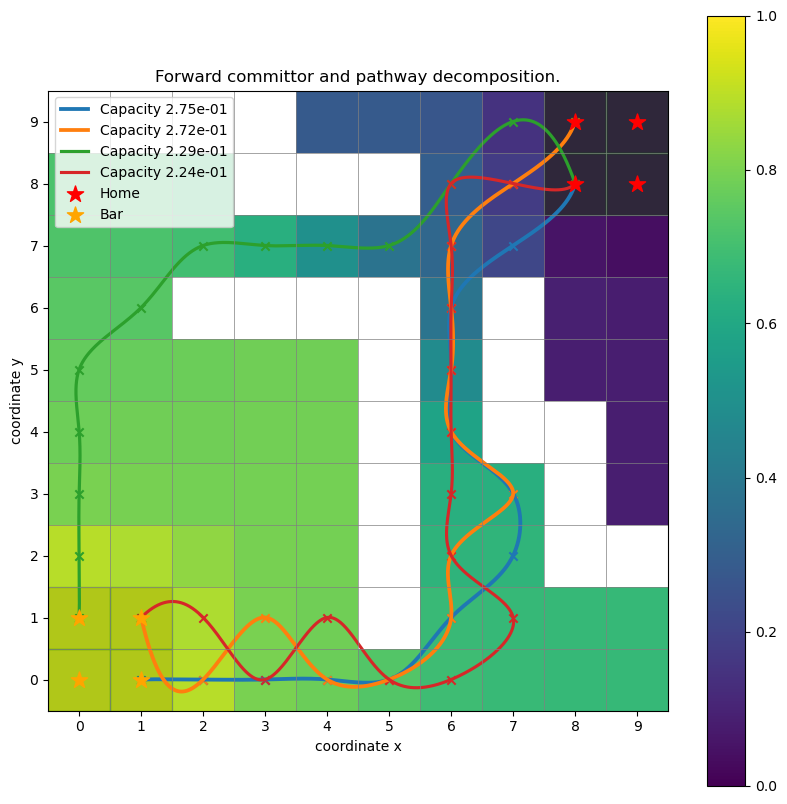

In [84]:
paths, capacities = flux.pathways(.3)

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Forward committor and pathway decomposition.")

for capacity, path in zip((capacities / np.array(capacities).sum())[:10], paths[:10]):
    path = mlmsm.count_model.states_to_symbols(path)
    path = np.array([sim.state_to_coordinate(state) for state in path])
    sim.plot_path(ax, path, lw=capacity*10, label=f"Capacity {capacity:.2e}",
                  intermediates=False, color_lerp=False)
    ax.scatter(*path.T, marker='x')

handles, labels = sim.plot_2d_map(ax, barriers=False)

Q = np.ones((sim.n_states))*np.nan
Q[mlmsm.state_symbols()] = flux.forward_committor
Q = Q.reshape(sim.grid_size)

cb = ax.imshow(Q, interpolation='nearest', origin='lower')
fig.colorbar(cb, ax=ax)

ax.legend(handles=handles, labels=labels);



> Comparing this plot with the ones above one can notice that the hard barriers are 'missing', meaning that they were not sampled in the trajectories and now show up as white cubes due to the image being initalized as $10 \times 10$ array filled with `np.nan`.

### Case 1.7: TPT Analysis on Double Well

We move back to the double well analysis from the original tutorial at this point. We'll start by computing mean first passage times between our coarse-grained set $A$ (one of the wells) and our coarse-grained set $B$ (the other of the wells) produced from the PCCA+ decomposition.  It's been long enough over on the drunkard's walk here that we will reload and rerun the PCCA+:

In [85]:
import pickle
fold = './data/'
fnames = ['step3-doublewell_cluster.pkl',
          'step3-doublewell_msm.pkl',
          'step3-doublewell_bayesian_msm.pkl']
varlist = []
for i in range(len(fnames)):
    f = open(fold+fnames[i],'rb')
    var = pickle.load(f)
    varlist.append(var)
    f.close()
    
cluster = varlist[0]
msm = varlist[1]
bayesian_msm = varlist[2]

n_metastable = 2
pcca = msm.pcca(n_metastable_sets=n_metastable)

file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']
assignments = cluster.transform(data)

In [89]:
setA = np.where(pcca.assignments)[0]
setB = np.where(pcca.assignments==0)[0]

In [94]:
fluxAB = msm.reactive_flux(setA.astype(int), setB.astype(int))

In [97]:
print(f'MFPT_AB = {fluxAB.mfpt:.3f} steps')

MFPT_AB = 20.386 steps


In [98]:
fluxBA = msm.reactive_flux(setB.astype(int), setA.astype(int))
print(f'MFPT_BA = {fluxBA.mfpt:.3f} steps')

MFPT_BA = 16.003 steps


So we come up with similar but not identical mean first passage times.  Let's try to put some errors on here by using the Bayesian MSM sampling technique instead.

In [103]:
print(bayesian_msm.gather_stats('mfpt',A=setA,B=setB))

QuantityStatistics(mean=20.467227673552813, std=0.4077434926397675)


In [104]:
print(bayesian_msm.gather_stats('mfpt',A=setB,B=setA))

QuantityStatistics(mean=15.977418009908344, std=0.2549260882984075)


(array([ 1.,  0.,  0.,  1.,  1.,  2.,  5.,  9., 17., 19., 19., 13.,  8.,
         3.,  2.]),
 array([14.89183679, 15.0047412 , 15.1176456 , 15.23055001, 15.34345442,
        15.45635882, 15.56926323, 15.68216764, 15.79507204, 15.90797645,
        16.02088086, 16.13378526, 16.24668967, 16.35959408, 16.47249848,
        16.58540289]),
 [<matplotlib.patches.Polygon at 0x1cb780506d0>])

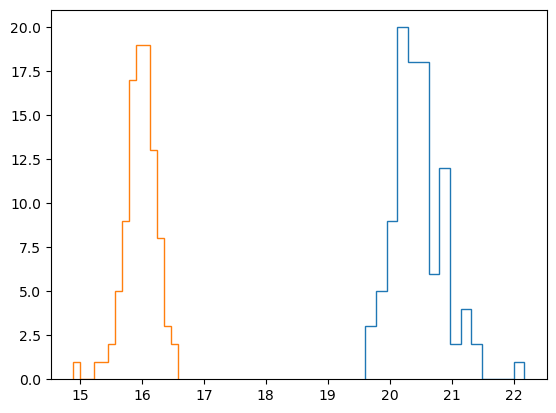

In [124]:
fig,ax = plt.subplots()
samplesAB = bayesian_msm.gather_stats('mfpt',A=setA,B=setB,store_samples=True).samples
ax.hist(samplesAB,bins=15,histtype='step')

samplesBA = bayesian_msm.gather_stats('mfpt',A=setB,B=setA,store_samples=True).samples
ax.hist(samplesBA,bins=15,histtype='step')

Note that `mfpt` can be calculated from the explicitly created `ReactiveFlux` object OR through the `BayesianMSM` interface, which will (I am pretty sure) create its own `flux` object given the sets -- as we see, the answers that are calculated are pretty similar for both.  The ability to calculate what the progammers think of as "standard" sorts of values is very useful but can obscure the underlying theory, so I recommend being cautious and making sure you understand what you're doing.

Our observations match the PyEmma tutorial, which notes

> We can clearly see that there is no overlap of the distributions approximated by the BayesianMSM.

The next thing to do is to do a bit more with TPT. We've already computed the flux directly, and now we're going to plot the committor.

In [142]:
flux.forward_committor

array([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.])

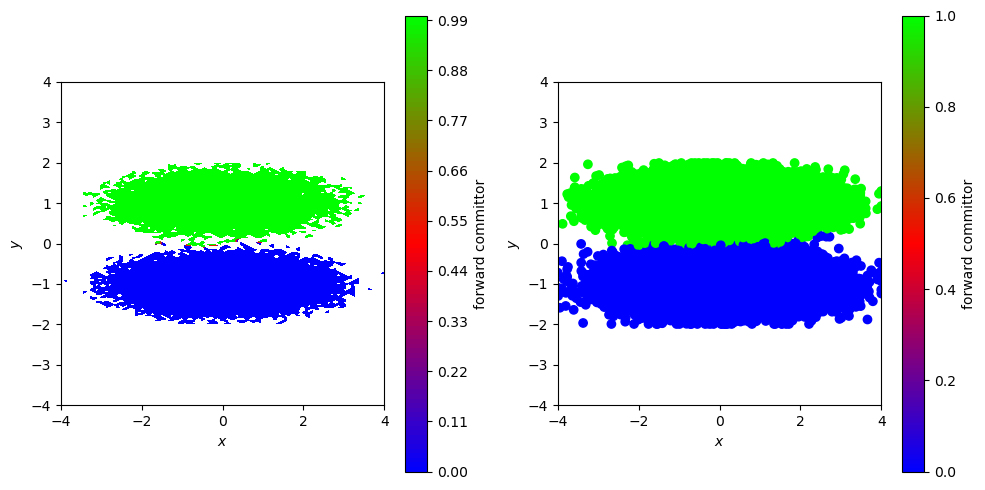

In [143]:
fig,axes= plt.subplots(1,2,figsize=(10,5))
pyemma.plots.plot_contour(
    *data.T, flux.forward_committor[assignments],
    cbar_label='forward committor',
    method='nearest', mask=True,ax=axes[0],cmap='brg')

axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_aspect('equal')

sp=axes[1].scatter(*data.T,c=flux.forward_committor[assignments],
                  cmap='brg')

axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
fig.colorbar(sp,ax=axes[1],label='forward committor')
fig.tight_layout()

From the PyEmma tutorial,

> We see that the committor for the double well data approximates a step function between the two basins. In other words, the probability of transitioning from metastable state A to B is only 1 if we already are in state B. If we are in A, it is 0 by definition. The clustering did not resolve the transition region, so this particular example does not provide more information. In the next example we will see more.

## Case 2: low-dimensional molecular dynamics data